In [5]:
from scipy.integrate import solve_ivp
from matplotlib.pyplot import subplots
from numpy import linspace, around, var, ndarray
from scipy.signal import find_peaks

# Model of Feedforward inhibition


In [12]:
def model(t, S, a1, b1, a2, b2, k_max, K_m, n, m):
    """Enzymatic Reaction with forward inhibition"""
    
    enzymatic_rate = (k_max * S**n) / (K_m**m + S**m)
    
    dSdt = a1 - b1 * S - enzymatic_rate
    
    return dSdt


## Time Series

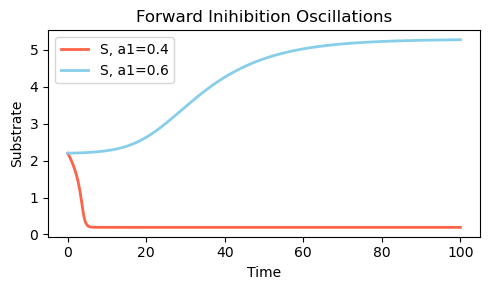

In [24]:
a1_pars  = [0.4, 0.6]

a2  = 0.01
b1, b2  = 0.1, 0.01
k_max, K_m = 2, 1
n, m    = 1, 3

S_0 = 2.2

y0 = [S_0]

t_span = (0, 100)


fig, ax = subplots(figsize=(5, 3))

colors = ['tomato', 'skyblue']

for index, a1 in enumerate(a1_pars):

    solution = solve_ivp(model, t_span, y0, args=(a1, b1, a2, b2, k_max, K_m, n, m), method='BDF', max_step=0.1)
    
    t = solution.t
    
    S = solution.y.T
        
    ax.plot(t, S, label=f'S, a1={a1}', linewidth=2, color=colors[index])

ax.set_xlabel('Time')
ax.set_ylabel('Substrate')
ax.legend()
ax.set_title('Forward Inihibition Oscillations')



fig.tight_layout()


# Analysis

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import cumulative_trapezoid

def dS_dt(S, a1, b1, k_max, K_m, n, m):
    """First equation only - S dynamics independent of P"""
    enzymatic_rate = (k_max * S**n) / (K_m**m + S**m)
    return a1 - b1 * S - enzymatic_rate

def find_steady_states_1D(a1, b1, k_max, K_m, n, m):
    """Find steady states for S equation"""
    steady_states = []
    
    # Try multiple initial guesses
    for S_guess in np.linspace(0.1, 15, 50):
        try:
            sol = fsolve(lambda S: dS_dt(S, a1, b1, k_max, K_m, n, m), 
                        S_guess, full_output=True)
            if sol[2] == 1:  # Converged
                S_star = sol[0][0]
                if S_star > 0:  # Positive solution
                    residual = abs(dS_dt(S_star, a1, b1, k_max, K_m, n, m))
                    if residual < 1e-8:
                        # Check if new
                        is_new = True
                        for existing in steady_states:
                            if abs(S_star - existing) < 1e-4:
                                is_new = False
                                break
                        if is_new:
                            steady_states.append(S_star)
        except:
            pass
    
    return sorted(steady_states)

def check_stability_1D(S_star, a1, b1, k_max, K_m, n, m, epsilon=1e-6):
    """Check stability by examining derivative of dS/dt at steady state"""
    # Compute df/dS at steady state
    f_plus = dS_dt(S_star + epsilon, a1, b1, k_max, K_m, n, m)
    f_minus = dS_dt(S_star - epsilon, a1, b1, k_max, K_m, n, m)
    derivative = (f_plus - f_minus) / (2 * epsilon)
    
    # Stable if derivative < 0
    is_stable = derivative < 0
    
    return is_stable, derivative

def compute_potential_1D(a1, b1, k_max, K_m, n, m, S_range=(0.1, 10), resolution=1000):
    """
    Compute 1D potential V(S) such that dS/dt = -dV/dS
    
    This means: V(S) = -∫ f(S) dS where f(S) = dS/dt
    """
    S_array = np.linspace(S_range[0], S_range[1], resolution)
    
    # Compute dS/dt for all S values
    dS_dt_array = np.array([dS_dt(S, a1, b1, k_max, K_m, n, m) for S in S_array])
    
    # Integrate to get potential: V(S) = -∫ (dS/dt) dS
    potential = cumulative_trapezoid(-dS_dt_array, S_array, initial=0)
    
    # Shift so minimum is at zero
    potential = potential - np.min(potential)
    
    return S_array, potential, dS_dt_array

def plot_1D_potential_comparison():
    """Plot 1D potential for both a1 values side by side"""
    
    # Parameters
    b1 = 0.1
    k_max, K_m = 2, 1
    n, m = 1, 3
    a1_values = [0.4, 0.6]
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 7))
    
    colors_stable = ['red', 'blue', 'green']
    colors_unstable = ['orange']
    
    for idx, a1 in enumerate(a1_values):
        # Find steady states
        steady_states = find_steady_states_1D(a1, b1, k_max, K_m, n, m)
        
        print(f"\n{'='*50}")
        print(f"a1 = {a1}")
        print(f"{'='*50}")
        print(f"Found {len(steady_states)} steady state(s):")
        
        stable_states = []
        unstable_states = []
        
        for i, S_star in enumerate(steady_states):
            is_stable, derivative = check_stability_1D(S_star, a1, b1, k_max, K_m, n, m)
            stability = "STABLE" if is_stable else "UNSTABLE"
            print(f"  S* = {S_star:.6f}  [{stability}]  (df/dS = {derivative:.6f})")
            
            if is_stable:
                stable_states.append(S_star)
            else:
                unstable_states.append(S_star)
        
        # Compute potential and force
        S_array, potential, force = compute_potential_1D(a1, b1, k_max, K_m, n, m)
        
        # Top row: Potential V(S)
        ax_pot = axes[0, idx]
        ax_pot.plot(S_array, potential, 'b-', linewidth=2.5, label='V(S)')
        ax_pot.fill_between(S_array, 0, potential, alpha=0.3)
        
        # Mark stable steady states on potential
        for i, S_star in enumerate(stable_states):
            V_star = np.interp(S_star, S_array, potential)
            ax_pot.plot(S_star, V_star, 'o', color='red', markersize=15,
                       markeredgecolor='white', markeredgewidth=2.5,
                       label=f'Stable: S*={S_star:.3f}', zorder=5)
        
        # Mark unstable steady states on potential
        for i, S_star in enumerate(unstable_states):
            V_star = np.interp(S_star, S_array, potential)
            ax_pot.plot(S_star, V_star, 'X', color='cyan', markersize=15,
                       markeredgecolor='white', markeredgewidth=2.5,
                       label=f'Unstable: S*={S_star:.3f}', zorder=5)
        
        ax_pot.set_xlabel('S (Substrate)', fontsize=12, fontweight='bold')
        ax_pot.set_ylabel('Potential V(S)', fontsize=12, fontweight='bold')
        ax_pot.set_title(f'Potential Landscape (a1={a1})', fontsize=13, fontweight='bold')
        ax_pot.legend(loc='best', fontsize=9)
        ax_pot.grid(True, alpha=0.3)
        ax_pot.set_ylim(bottom=-0.1)
        
        # Bottom row: Phase portrait (dS/dt vs S)
        ax_phase = axes[1, idx]
        ax_phase.plot(S_array, force, 'g-', linewidth=2.5, label='dS/dt')
        ax_phase.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
        ax_phase.fill_between(S_array, 0, force, where=(force > 0), 
                             alpha=0.3, color='blue', label='S increases')
        ax_phase.fill_between(S_array, 0, force, where=(force < 0), 
                             alpha=0.3, color='red', label='S decreases')
        
        # Mark stable steady states
        for i, S_star in enumerate(stable_states):
            ax_phase.plot(S_star, 0, 'o', color='red', markersize=15,
                         markeredgecolor='white', markeredgewidth=2.5, zorder=5)
            # Add arrows showing stability
            ax_phase.annotate('', xy=(S_star, 0), xytext=(S_star - 0.3, 0),
                            arrowprops=dict(arrowstyle='->', color='red', lw=2))
            ax_phase.annotate('', xy=(S_star, 0), xytext=(S_star + 0.3, 0),
                            arrowprops=dict(arrowstyle='->', color='red', lw=2))
        
        # Mark unstable steady states
        for i, S_star in enumerate(unstable_states):
            ax_phase.plot(S_star, 0, 'X', color='cyan', markersize=15,
                         markeredgecolor='white', markeredgewidth=2.5, zorder=5)
            # Add arrows showing instability
            ax_phase.annotate('', xy=(S_star - 0.3, 0), xytext=(S_star, 0),
                            arrowprops=dict(arrowstyle='->', color='orange', lw=2))
            ax_phase.annotate('', xy=(S_star + 0.3, 0), xytext=(S_star, 0),
                            arrowprops=dict(arrowstyle='->', color='orange', lw=2))
        
        ax_phase.set_xlabel('S (Substrate)', fontsize=12, fontweight='bold')
        ax_phase.set_ylabel('dS/dt (Rate)', fontsize=12, fontweight='bold')
        ax_phase.set_title(f'Phase Portrait (a1={a1})', fontsize=13, fontweight='bold')
        ax_phase.legend(loc='best', fontsize=9)
        ax_phase.grid(True, alpha=0.3)
    
    plt.tight_layout()
    # plt.savefig('potential_1D_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_combined_bifurcation():
    """Plot bifurcation diagram showing transition from monostable to bistable"""
    
    b1 = 0.1
    k_max, K_m = 2, 1
    n, m = 1, 3
    
    # Scan a1 values
    a1_values = np.linspace(0.3, 0.7, 100)
    
    all_stable = []
    all_unstable = []
    all_a1_stable = []
    all_a1_unstable = []
    
    for a1 in a1_values:
        steady_states = find_steady_states_1D(a1, b1, k_max, K_m, n, m)
        
        for S_star in steady_states:
            is_stable, _ = check_stability_1D(S_star, a1, b1, k_max, K_m, n, m)
            
            if is_stable:
                all_stable.append(S_star)
                all_a1_stable.append(a1)
            else:
                all_unstable.append(S_star)
                all_a1_unstable.append(a1)
    
    # Plot bifurcation diagram
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    if all_a1_stable:
        ax.plot(all_a1_stable, all_stable, 'o', color='red', 
               markersize=3, label='Stable steady states', alpha=0.7)
    if all_a1_unstable:
        ax.plot(all_a1_unstable, all_unstable, 'x', color='cyan', 
               markersize=4, label='Unstable steady states', alpha=0.7)
    
    ax.axvline(x=0.4, color='gray', linestyle='--', linewidth=2, 
              alpha=0.5, label='a1=0.4 (monostable)')
    ax.axvline(x=0.6, color='black', linestyle='--', linewidth=2, 
              alpha=0.5, label='a1=0.6 (bistable)')
    
    ax.set_xlabel('a1 (control parameter)', fontsize=12, fontweight='bold')
    ax.set_ylabel('S* (steady state)', fontsize=12, fontweight='bold')
    ax.set_title('Bifurcation Diagram: Saddle-Node Bifurcation', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    # plt.savefig('bifurcation_diagram_1D.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run the analysis
print("="*37)
print("|| 1D POTENTIAL LANDSCAPE ANALYSIS ||")
print("="*37)


|| 1D POTENTIAL LANDSCAPE ANALYSIS ||


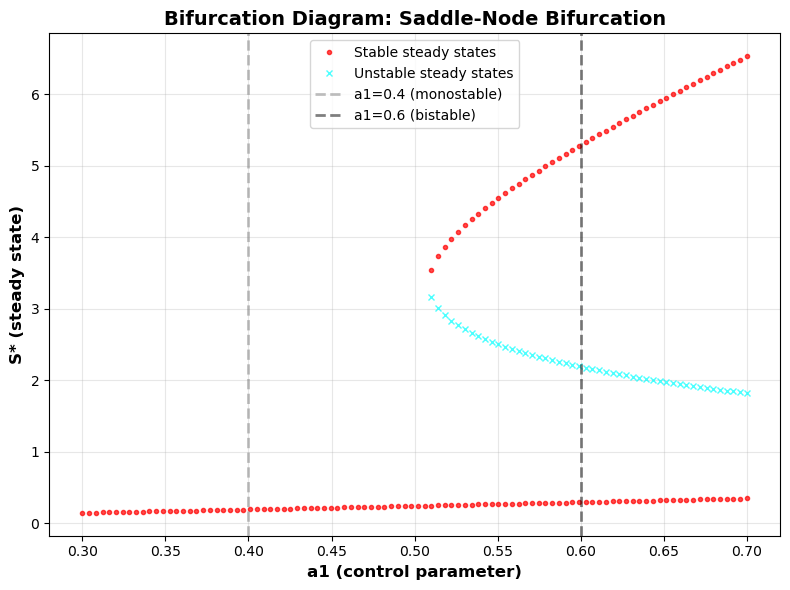

In [26]:
plot_combined_bifurcation()


a1 = 0.4
Found 1 steady state(s):
  S* = 0.191755  [STABLE]  (df/dS = -2.044283)

a1 = 0.6
Found 3 steady state(s):
  S* = 0.292517  [STABLE]  (df/dS = -1.908231)
  S* = 2.188791  [UNSTABLE]  (df/dS = 0.202769)
  S* = 5.290141  [STABLE]  (df/dS = -0.073433)


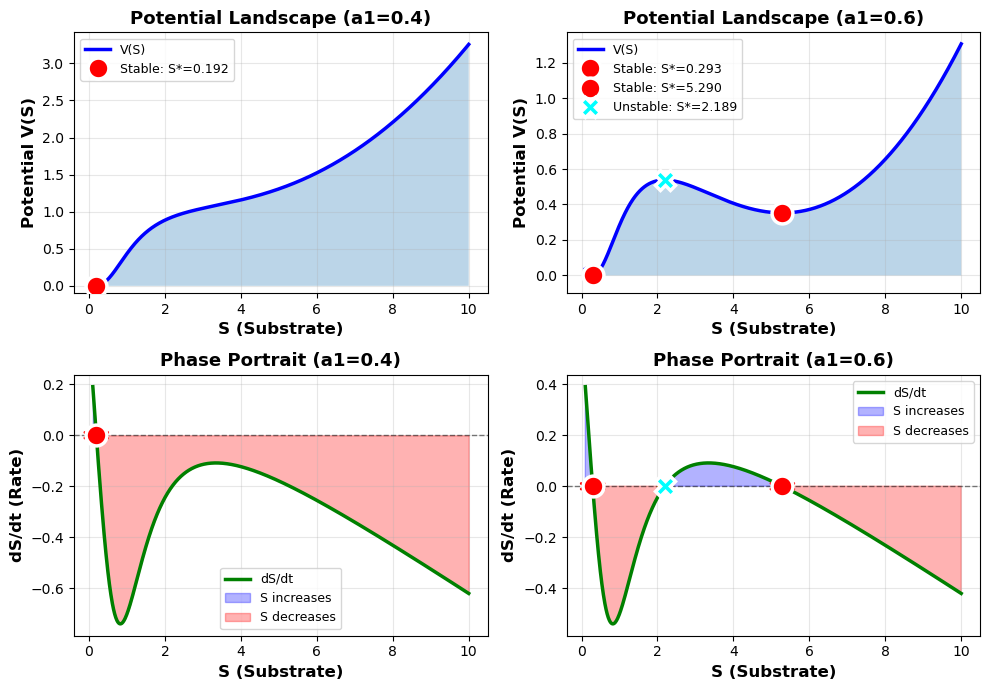

In [2]:
plot_1D_potential_comparison()


# Plotly graph

INTERACTIVE 'WADDINGTON' LANDSCAPE
Computing interactive Waddington landscape...

✓ Interactive plot saved to: waddington_landscape_interactive.html


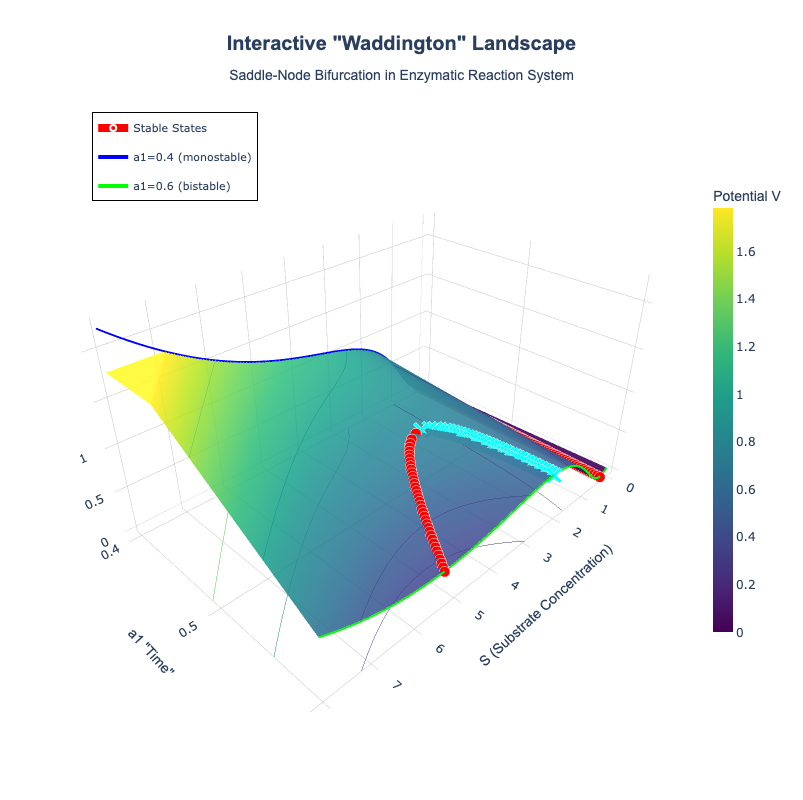


EXPORT OPTIONS:
1. Open 'waddington_landscape_interactive.html' in your browser
2. Interactive controls:
   - Rotate: Click and drag
   - Zoom: Scroll or pinch
   - Pan: Right-click and drag
   - Reset view: Double-click
3. Download static PNG using camera icon in toolbar
4. HTML file is self-contained and shareable!


In [3]:
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import fsolve
from scipy.integrate import cumulative_trapezoid

def dS_dt(S, a1, b1, k_max, K_m, n, m):
    """First equation only - S dynamics independent of P"""
    enzymatic_rate = (k_max * S**n) / (K_m**m + S**m)
    return a1 - b1 * S - enzymatic_rate

def find_steady_states_1D(a1, b1, k_max, K_m, n, m):
    """Find steady states for S equation"""
    steady_states = []
    for S_guess in np.linspace(0.1, 15, 50):
        try:
            sol = fsolve(lambda S: dS_dt(S, a1, b1, k_max, K_m, n, m), 
                        S_guess, full_output=True)
            if sol[2] == 1:
                S_star = sol[0][0]
                if S_star > 0:
                    residual = abs(dS_dt(S_star, a1, b1, k_max, K_m, n, m))
                    if residual < 1e-8:
                        is_new = True
                        for existing in steady_states:
                            if abs(S_star - existing) < 1e-4:
                                is_new = False
                                break
                        if is_new:
                            steady_states.append(S_star)
        except:
            pass
    
    return sorted(steady_states)

def check_stability_1D(S_star, a1, b1, k_max, K_m, n, m, epsilon=1e-6):
    """Check stability by examining derivative of dS/dt at steady state"""
    f_plus = dS_dt(S_star + epsilon, a1, b1, k_max, K_m, n, m)
    f_minus = dS_dt(S_star - epsilon, a1, b1, k_max, K_m, n, m)
    derivative = (f_plus - f_minus) / (2 * epsilon)
    is_stable = derivative < 0
    return is_stable, derivative

def compute_potential_1D(a1, b1, k_max, K_m, n, m, S_range=(0.1, 10), resolution=1000):
    """Compute 1D potential V(S) such that dS/dt = -dV/dS"""
    S_array = np.linspace(S_range[0], S_range[1], resolution)
    dS_dt_array = np.array([dS_dt(S, a1, b1, k_max, K_m, n, m) for S in S_array])
    potential = cumulative_trapezoid(-dS_dt_array, S_array, initial=0)
    potential = potential - np.min(potential)
    return S_array, potential, dS_dt_array

def separate_branches(S_vals, a1_vals, V_vals, stability_vals, threshold=0.5):
    """Separate steady state trajectories into continuous branches"""
    branches = []
    current_branch = {'S': [], 'a1': [], 'V': [], 'stable': None}
    
    for i in range(len(S_vals)):
        if i == 0:
            current_branch['S'].append(S_vals[i])
            current_branch['a1'].append(a1_vals[i])
            current_branch['V'].append(V_vals[i])
            current_branch['stable'] = stability_vals[i]
        else:
            # Check if this point is continuous with the current branch
            if (abs(S_vals[i] - S_vals[i-1]) < threshold and 
                stability_vals[i] == current_branch['stable']):
                current_branch['S'].append(S_vals[i])
                current_branch['a1'].append(a1_vals[i])
                current_branch['V'].append(V_vals[i])
            else:
                # Start a new branch
                if len(current_branch['S']) > 0:
                    branches.append(current_branch)
                current_branch = {
                    'S': [S_vals[i]], 
                    'a1': [a1_vals[i]], 
                    'V': [V_vals[i]], 
                    'stable': stability_vals[i]
                }
    
    # Don't forget the last branch
    if len(current_branch['S']) > 0:
        branches.append(current_branch)
    
    return branches

def create_interactive_waddington_landscape():
    """Create an interactive 3D Waddington landscape using Plotly"""
    # Parameters
    b1 = 0.1
    k_max, K_m = 2, 1
    n, m = 1, 3
    
    # Create arrays with high resolution
    a1_array = np.linspace(0.4, 0.6, 80)
    S_range = (0.05, 8)  # FIXED: Start from much lower value to see low steady state
    S_resolution = 500
    
    # Initialize potential matrix
    S_array = np.linspace(S_range[0], S_range[1], S_resolution)
    potential_matrix = np.zeros((len(a1_array), S_resolution))
    
    # Store steady states
    all_steady_states = []
    all_a1_for_states = []
    all_stability = []
    all_V_for_states = []
    
    print("Computing interactive Waddington landscape...")
    for i, a1 in enumerate(a1_array):
        _, potential, _ = compute_potential_1D(a1, b1, k_max, K_m, n, m, 
                                               S_range, S_resolution)
        potential_matrix[i, :] = potential
        
        steady_states = find_steady_states_1D(a1, b1, k_max, K_m, n, m)
        for S_star in steady_states:
            is_stable, _ = check_stability_1D(S_star, a1, b1, k_max, K_m, n, m)
            V_star = np.interp(S_star, S_array, potential)
            all_steady_states.append(S_star)
            all_a1_for_states.append(a1)
            all_stability.append(is_stable)
            all_V_for_states.append(V_star)
    
    # Create meshgrid
    S_mesh, a1_mesh = np.meshgrid(S_array, a1_array)
    
    # Cap the potential for better visualization
    V_plot = potential_matrix.copy()
    V_max = np.percentile(V_plot, 98)
    V_plot = np.clip(V_plot, 0, V_max)
    
    # FIXED: Separate branches to avoid connecting discontinuous points
    branches = separate_branches(
        all_steady_states, 
        all_a1_for_states, 
        all_V_for_states, 
        all_stability,
        threshold=0.5  # Adjust this if needed
    )
    
    # Create the figure
    fig = go.Figure()
    
    # Add the main surface
    fig.add_trace(go.Surface(
        x=S_mesh,
        y=a1_mesh,
        z=V_plot,
        colorscale='Viridis',
        opacity=0.95,
        name='Potential Landscape',
        colorbar=dict(
            title=dict(
                text='Potential V',
                font=dict(size=14, family='Arial, sans-serif')
            ),
            tickfont=dict(size=12),
            len=0.75,
            thickness=20
        ),
        contours=dict(
            z=dict(
                show=True,
                usecolormap=True,
                highlightcolor="white",
                project=dict(z=True)
            )
        ),
        hovertemplate='<b>S</b>: %{x:.3f}<br><b>a1</b>: %{y:.3f}<br><b>V</b>: %{z:.3f}<extra></extra>'
    ))
    
    # FIXED: Add each branch separately as lines+markers
    for i, branch in enumerate(branches):
        if branch['stable']:
            fig.add_trace(go.Scatter3d(
                x=branch['S'],
                y=branch['a1'],
                z=branch['V'],
                mode='lines+markers',
                name=f'Stable Branch {i+1}' if i > 0 else 'Stable States',
                line=dict(color='red', width=8),
                marker=dict(
                    size=6,
                    color='red',
                    symbol='circle',
                    line=dict(color='white', width=2)
                ),
                showlegend=(i == 0),  # Only show legend for first stable branch
                legendgroup='stable',
                hovertemplate='<b>Stable State</b><br>S: %{x:.4f}<br>a1: %{y:.4f}<br>V: %{z:.4f}<extra></extra>'
            ))
        else:
            fig.add_trace(go.Scatter3d(
                x=branch['S'],
                y=branch['a1'],
                z=branch['V'],
                mode='lines+markers',
                name=f'Unstable Branch {i+1}' if i > 0 else 'Unstable States',
                line=dict(color='cyan', width=8, dash='dash'),
                marker=dict(
                    size=4,
                    color='cyan',
                    symbol='x',
                    line=dict(color='white', width=2)
                ),
                showlegend=(i == 0),  # Only show legend for first unstable branch
                legendgroup='unstable',
                hovertemplate='<b>Unstable State</b><br>S: %{x:.4f}<br>a1: %{y:.4f}<br>V: %{z:.4f}<extra></extra>'
            ))
    
    # Add reference planes
    idx_04 = np.argmin(np.abs(a1_array - 0.4))
    S_plane = np.linspace(S_range[0], S_range[1], 50)
    a1_plane_04 = np.full_like(S_plane, 0.4)
    V_plane_04 = np.interp(S_plane, S_array, potential_matrix[idx_04, :])
    
    fig.add_trace(go.Scatter3d(
        x=S_plane,
        y=a1_plane_04,
        z=V_plane_04,
        mode='lines',
        name='a1=0.4 (monostable)',
        line=dict(color='blue', width=4),
        hovertemplate='<b>a1=0.4</b><br>S: %{x:.3f}<br>V: %{z:.3f}<extra></extra>'
    ))
    
    idx_06 = np.argmin(np.abs(a1_array - 0.6))
    a1_plane_06 = np.full_like(S_plane, 0.6)
    V_plane_06 = np.interp(S_plane, S_array, potential_matrix[idx_06, :])
    
    fig.add_trace(go.Scatter3d(
        x=S_plane,
        y=a1_plane_06,
        z=V_plane_06,
        mode='lines',
        name='a1=0.6 (bistable)',
        line=dict(color='lime', width=4),
        hovertemplate='<b>a1=0.6</b><br>S: %{x:.3f}<br>V: %{z:.3f}<extra></extra>'
    ))
    
    # Update layout
    fig.update_layout(
        title=dict(
            text='<b>Interactive "Waddington" Landscape</b><br>' +
                 '<sub>Saddle-Node Bifurcation in Enzymatic Reaction System</sub>',
            x=0.5,
            xanchor='center',
            font=dict(size=20, family='Arial, sans-serif')
        ),
        scene=dict(
            xaxis=dict(
                title=dict(text='S (Substrate Concentration)', 
                          font=dict(size=14, family='Arial, sans-serif')),
                gridcolor='lightgray',
                showbackground=True,
                backgroundcolor='rgba(230, 230, 230, 0.5)'
            ),
            yaxis=dict(
                title=dict(text='a1 "Time"', 
                          font=dict(size=14, family='Arial, sans-serif')),
                gridcolor='lightgray',
                showbackground=True,
                backgroundcolor='rgba(230, 230, 230, 0.5)'
            ),
            zaxis=dict(
                title=dict(text='Potential V(S, a1)', 
                          font=dict(size=14, family='Arial, sans-serif')),
                gridcolor='lightgray',
                showbackground=True,
                backgroundcolor='rgba(230, 230, 230, 0.5)'
            ),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.3),
                center=dict(x=0, y=0, z=0)
            ),
            aspectmode='manual',
            aspectratio=dict(x=1.5, y=1, z=0.8)
        ),
        width=1200,
        height=800,
        showlegend=True,
        legend=dict(
            x=0.02,
            y=0.98,
            bgcolor='rgba(255, 255, 255, 0.8)',
            bordercolor='black',
            borderwidth=1,
            font=dict(size=11)
        ),
        hovermode='closest',
        template='plotly_white'
    )
    
    # Save to HTML
    html_file = 'waddington_landscape_interactive.html'
    fig.write_html(html_file)
    print(f"\n✓ Interactive plot saved to: {html_file}")
    
    # Show the plot
    fig.show()
    
    return fig

# Run the interactive Plotly analysis
print("="*60)
print("INTERACTIVE 'WADDINGTON' LANDSCAPE")
print("="*60)
fig1 = create_interactive_waddington_landscape()
print("\n" + "="*60)
print("EXPORT OPTIONS:")
print("="*60)
print("1. Open 'waddington_landscape_interactive.html' in your browser")
print("2. Interactive controls:")
print("   - Rotate: Click and drag")
print("   - Zoom: Scroll or pinch")
print("   - Pan: Right-click and drag")
print("   - Reset view: Double-click")
print("3. Download static PNG using camera icon in toolbar")
print("4. HTML file is self-contained and shareable!")
print("="*60)